# Uncertainty-Aware Road Obstacle Identification (UAROI)

---

**Final Project and Exam $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Computer Vision | Sapienza Università di Roma**

---

* Jose Edgar Hernandez Cancino Estrada | 2223606
* Marcelo Jimenez Da Fonseca | 2224588
* Enrique Favila Martinez | 2223610

## Conformal Risk Control and Unknown Object Score Evaluation

In this notebook, the **LostAndFound** dataset is used to evaluate a model's ability to detect small, unexpected obstacles on the road—especially those not seen during training (out-of-distribution or OOD). This dataset is designed to test the robustness of perception systems for self-driving vehicles in challenging scenarios involving rare or unknown objects.

The dataset consists of high-resolution stereo images with pixel-wise segmentation labels indicating various types of road hazards (e.g., lost cargo, small road debris) as well as background classes like road and sidewalk.

In our setup:
- The model is **trained on Cityscapes**, which does not contain these small hazards.
- The **LostAndFound dataset is used exclusively for evaluation**, providing a realistic benchmark for unknown object detection.


---

**References**

- Pinggera, P., Ramos, S., Gehrig, S., Franke, U., Rother, C., & Mester, R. (2016). *Lost and found: Detecting small road hazards for self-driving vehicles*. In *2016 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS)*, pp. 1099–1106. IEEE. [https://doi.org/10.1109/IROS.2016.7759183](https://doi.org/10.1109/IROS.2016.7759183)

- Sakaridis, C., Dai, D., & Van Gool, L. (2019). *Road Obstacle Detection based on Unknown Objectness Scores*. [https://arxiv.org/abs/1905.07477](https://arxiv.org/abs/1905.07477)

# Imports and downloads

In [36]:
# Imports
import os
import torch
import tarfile
import torch.nn as nn
import numpy as np
import pathlib,zipfile
from tqdm import tqdm

from google.colab import drive
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

In [37]:
# # !pip install --upgrade gdown
# !gdown --folder https://drive.google.com/drive/folders/1-VEDc9kRDWo2pcsmBJnefwZEcV4qkNk7 -O dataset

In [38]:
# !gdown --folder https://drive.google.com/drive/folders/1X_sie38bSouwjZVhEQQuzjMd5YJ0Lht9 -O dataset

In [39]:
def unzip(zip_path, dest):
    zip_path = pathlib.Path(zip_path)
    dest = pathlib.Path(dest)
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Get the list of files in the zip for the progress bar
        file_list = z.namelist()
        # Use tqdm to wrap the iteration over the file list
        for file in tqdm(file_list, desc=f"Extracting {zip_path.name}", unit="file"):
            # Extract each file individually
            z.extract(file, dest)
    print("done!")

In [40]:
# Config
# drive.mount('/content/drive')
# train_laf_path  = '/content/drive/MyDrive/Colab Notebooks/EMAI - Sapienza/Computer Vision/laf_train.tar.gz'
# test_laf_path   = '/content/drive/MyDrive/Colab Notebooks/EMAI - Sapienza/Computer Vision/laf_test.tar.gz'
extract_dir     = '/content/laf_data'
# model_weights   = '/content/drive/MyDrive/Colab Notebooks/EMAI - Sapienza/Computer Vision/uaroi_weights.pth'

model_weights = '/content/dataset/epoch_11_boundary_aware.pth'


train_laf_path  = '/content/dataset/laf_train.tar.gz'
test_laf_path   = '/content/dataset/laf_test.tar.gz'

LOCAL_PATH = "/content/dataset"

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device")
else:
    device = torch.device("cpu")
    print("Using CPU")

DEVICE = device

Using CUDA device: NVIDIA L4


In [41]:
# # Execute
# # unzip(model_weights_zip, model_weights_folder)
# os.makedirs(extract_dir, exist_ok=True)
# with tarfile.open(train_laf_path, "r:gz") as tar:
#     tar.extractall(path=extract_dir)
# with tarfile.open(test_laf_path, "r:gz") as tar:
#     tar.extractall(path=extract_dir)

# Utils

### LostAndFound Dataset

In [42]:
class LostAndFound(Dataset):
    def __init__(self, folder, binarize=False, device='cuda'):
        self.files = sorted([
            os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.pt')
        ])
        self.binarize = binarize
        self.device = device

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        image = data['image'].permute(2, 0, 1).float() / 255.0  # [3, H, W]
        mask = data['mask'].float()                            # [H, W]

        if self.binarize:
            mask = (mask > 1).float()  # Anything > 1 → 1, else 0

        mask = mask.unsqueeze(0)  # [1, H, W]
        return image.to(self.device), mask.to(self.device)

    def visualize(self, idx):
      image, mask = self[idx]
      image_np = image.permute(1, 2, 0).cpu().numpy()
      mask_np = mask.squeeze().cpu().numpy()

      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.imshow(image_np)
      plt.title("Original Image")
      plt.axis("off")

      plt.subplot(1, 2, 2)
      plt.imshow(image_np * 0.8)
      plt.imshow(mask_np, alpha=0.65, cmap='plasma')
      plt.title("Segmentation Mask")
      plt.axis("off")

      plt.show()

    def visualize_uos(self, idx, unkown_obj_score, unknown_score, objectness_score):
      image, mask = self[idx]
      image_np = image.permute(1, 2, 0).cpu().numpy()
      mask_np = mask.squeeze().cpu().numpy()
      uos_np = unkown_obj_score.cpu().numpy()
      unknown_class_score_np = unknown_score.cpu().numpy()
      objectness_score_np = objectness_score.cpu().numpy()

      fig, axs = plt.subplots(1, 4, figsize=(22, 6))
      titles = [
          "Segmentation Mask",
          "Objectness Class Prediction",
          "Unknown Class Score",
          "Unknown Object Score"
      ]

      # 1. Segmentation Mask (stronger alpha on object pixels)
      axs[0].imshow(image_np * 0.8)
      axs[0].imshow(mask_np, alpha=0.42, cmap='plasma')
      axs[0].set_title(titles[0], fontsize=16)
      axs[0].axis("off")

      # 2. Objectness Score
      axs[1].imshow(image_np * 0.8)
      axs[1].imshow(objectness_score_np, alpha=0.65, cmap='plasma')
      axs[1].set_title(titles[1], fontsize=16)
      axs[1].axis("off")

      # 3. Unknown Class Score
      axs[2].imshow(image_np * 0.8)
      im_unk_class = axs[2].imshow(unknown_class_score_np, cmap='hot', alpha=0.8)
      axs[2].set_title(titles[2], fontsize=16)
      axs[2].axis("off")
      cbar1 = fig.colorbar(im_unk_class, ax=axs[2], fraction=0.046, pad=0.02)
      cbar1.ax.tick_params(labelsize=10)

      # 4. Unknown Object Score (UOS)
      axs[3].imshow(image_np * 0.8)
      im_uos = axs[3].imshow(uos_np, cmap='hot', alpha=0.8)
      axs[3].set_title(titles[3], fontsize=16)
      axs[3].axis("off")
      cbar2 = fig.colorbar(im_uos, ax=axs[3], fraction=0.046, pad=0.02)
      cbar2.ax.tick_params(labelsize=10)

      plt.tight_layout()
      plt.show()

In [43]:
def visualize_unknown_detection(rgb_image, unk_obj_score, gt_mask, threshold=0.5, index=None):
    """
    Shows:
    - Original RGB image
    - Unknown object score (heatmap)
    - Binary prediction (thresholded)
    - Ground truth mask

    Args:
        rgb_image (Tensor): [3, H, W] image
        unk_obj_score (Tensor): [H, W] float tensor (values 0-1)
        gt_mask (Tensor): [H, W] binary mask
        threshold (float): Threshold to binarize the score
        index (int): Optional index for title
    """
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(rgb_image.permute(1, 2, 0).cpu())
    axs[0].set_title("RGB Image" if index is None else f"Image {index}")
    axs[0].axis("off")

    im1 = axs[1].imshow(unk_obj_score.cpu(), cmap='inferno', vmin=0, vmax=1)
    axs[1].set_title("Unk. Object Score")
    axs[1].axis("off")
    fig.colorbar(im1, ax=axs[1], shrink=0.7)

    axs[2].imshow((unk_obj_score > threshold).cpu(), cmap='gray')
    axs[2].set_title(f"Unk Object Score > {threshold}")
    axs[2].axis("off")

    axs[3].imshow(gt_mask.cpu(), cmap='gray')
    axs[3].set_title("Ground Truth Mask")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()


## Model

In [44]:
class DeepLabV3_SigmoidHead(nn.Module):
    def __init__(self, num_classes,  weights_path=None):
        super().__init__()
        self.num_classes = num_classes

        # Load pretrained DeepLabV3
        if weights_path and os.path.exists(weights_path):
            backbone = deeplabv3_resnet50(weights=None)
        else:
            backbone = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

        # Remove the classifier
        self.backbone_features = backbone.backbone
        self.aspp = backbone.classifier[0]  # ASPP module
        # Custom sigmoid head
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Conv2d(256, num_classes + 1, kernel_size=1),
                                        # nn.Sigmoid() # RIGHT NOW IT IS COMMENTED AS WE WILL TRAIN USING torch.nn.BCEWithLogitsLoss
                                        )
        if weights_path:
            self.load_weights(weights_path)

    def forward(self, x):
        input_shape = x.shape[-2:]
        # Extract features
        features = self.backbone_features(x)
        # Apply ASPP
        x = self.aspp(features['out'])
        # Apply classifier with sigmoid
        x = self.classifier(x)
        # Upsample to input resolution
        x = nn.functional.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

    def load_weights(self, path):
      if not os.path.exists(path):
          print("No model weights found at:", path)

      # Load the state dictionary directly from the file
      state_dict = torch.load(path)
      self.load_state_dict(state_dict)

    def save_weights(self, path):
      torch.save(self.state_dict(), path)

    def unknown_obj_scores(self, image, uos_only = True):
      self.eval()
      with torch.no_grad():
        input_tensor = image.unsqueeze(0)  # [1,3,H,W]
        output = self(input_tensor)                 # [1,num_classes (8),H,W]
        pred_mask = torch.sigmoid(output).squeeze(0).cpu()  # [num_classes (8),H,W] -> Dimension 0 will contain predictions for each of the num_classes classes

        # Get the unknown scores (1 - product_{k=1}^{K} (1 - p_{ik})) for each pixel i
        known_class_probs = pred_mask[:7,:,:] # Shape: [7, H, W]
        inv_known_class_probs = 1 - known_class_probs
        unknown_score = torch.prod(inv_known_class_probs, dim=0) # Shape: [H, W]

        objectness_score = pred_mask[7,:,:] # Shape: [H, W]
        unkown_obj_score = unknown_score * objectness_score # Pixel-Wise | Shape: [H, W]

        if uos_only:
          return unkown_obj_score
        else:
          return unkown_obj_score, unknown_score, objectness_score, pred_mask



# Dataset

Original training dataset size: 1036
Original test dataset size: 1203
Calibration dataset size: 100
Reduced training dataset size: 936


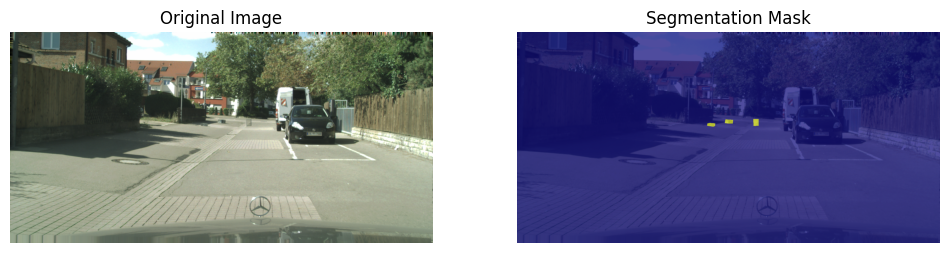

Image shape: torch.Size([3, 1024, 2048])
Mask shape: torch.Size([1, 1024, 2048])


In [45]:
# Define the size of the calibration set
calibration_size = 100
dataset_train = LostAndFound('/content/laf_data/laf_train', binarize=True, device=str(DEVICE))
dataset_test = LostAndFound('/content/laf_data/laf_test', binarize=True, device=str(DEVICE))
print(f"Original training dataset size: {len(dataset_train)}")
print(f"Original test dataset size: {len(dataset_test)}")

# Calculate the size of the remaining training set
train_size_after_calibration = len(dataset_train) - calibration_size
dataset_calibration = torch.utils.data.Subset(dataset_train, list(range(calibration_size)))
dataset_train= torch.utils.data.Subset(dataset_train, list(range(calibration_size, len(dataset_train))))


print(f"Calibration dataset size: {len(dataset_calibration)}")
print(f"Reduced training dataset size: {len(dataset_train)}")


train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)
test_loader  = DataLoader(dataset_test, batch_size=4, shuffle=False, num_workers=4)

idx = 199
idx2=787
dataset_test.visualize(idx)

img, mask = dataset_test[idx]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Model

In [46]:
""" MODEL DEFINITION
  Create model for Cityscapes with 7 grouped classes + objectness
  As mentioned in the paper:
  1. "road"
  2. "flat(w/o road)"
  3. "human"
  4. "vehicle"
  5. "construction"
  6. "object"
  7. "background"
"""

model = DeepLabV3_SigmoidHead(num_classes=7, weights_path=model_weights)
model = model.to(DEVICE)

# Unknown Objectness Score (UOS): Random Sample Visualization

Random Indices: [1177, 953, 50]


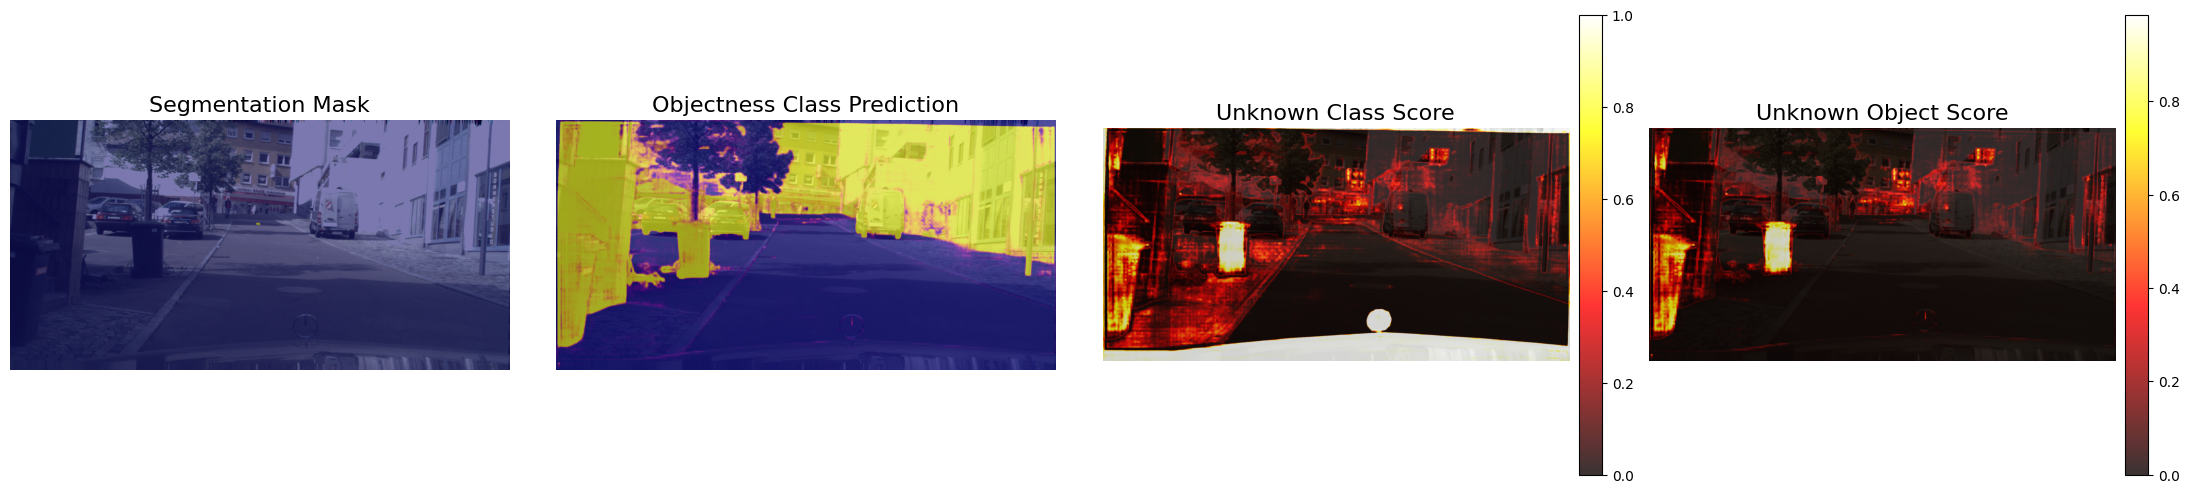

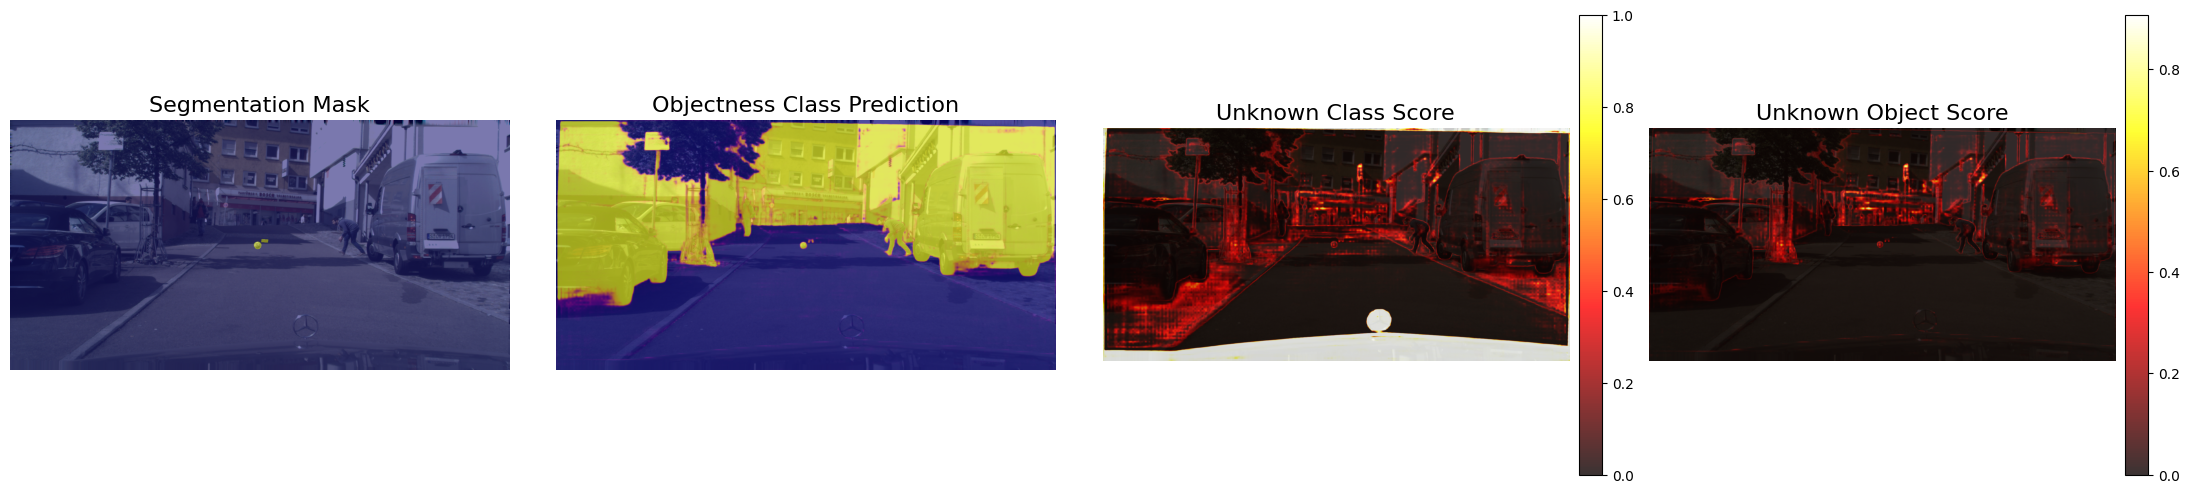

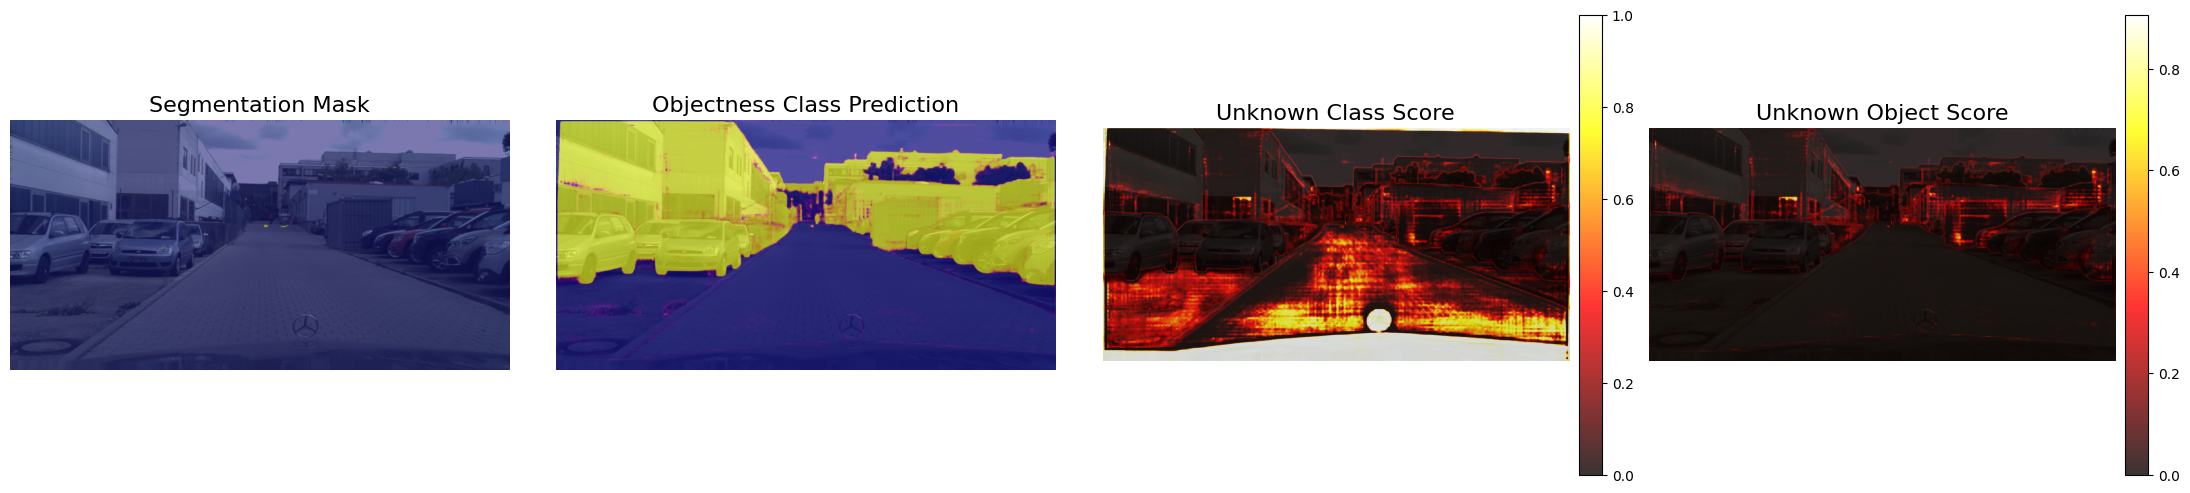

In [47]:
df = dataset_test

import random
indices = random.sample(range(len(dataset_test)), 3)
print(f"Random Indices: {indices}")

for idx in indices:
  image, mask = df[idx]
  unknown_obj_score, unknown_score, objectness_score, pred_mask = model.unknown_obj_scores(image, uos_only=False)
  df.visualize_uos(idx, unknown_obj_score, unknown_score, objectness_score)


In [48]:
dc = dataset_calibration
print(len(dataset_calibration))
all_gt_mask = []
all_unk_obj_score = []
for idx in tqdm(range(len(dataset_calibration))):
  image, mask = dc[idx]
  unknown_obj_score = model.unknown_obj_scores(image, uos_only=True)
  all_unk_obj_score.append(unknown_obj_score)
  all_gt_mask.append(mask)

gt_masks_tensor = torch.stack(all_gt_mask, dim=0)
unknown_obj_score_tensor = torch.stack(all_unk_obj_score, dim=0)


100


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


In [49]:
# Convert torch tensor to numpy
uos_numpy = unknown_obj_score_tensor.numpy()
gt_numpy = gt_masks_tensor.cpu().numpy()
np.savez_compressed("unk_obj_scores.npz", uos=uos_numpy)
np.savez_compressed("gt_mask_uos.npz",  gt = gt_numpy)
del all_gt_mask, gt_masks_tensor
del all_unk_obj_score, unknown_obj_score_tensor


#Conformal Risk Control Calibration using LostAndFound training set

In [50]:
#@title Import Unknown object scores
import numpy as np
uos = np.load('unk_obj_scores.npz')['uos']
gt_masks = np.load('gt_mask_uos.npz')['gt']
gt_masks = gt_masks.squeeze(1)

print(f"uos.shape: {uos.shape}")
print(f"gt_mask.shape: {gt_masks.shape}")

uos.shape: (100, 1024, 2048)
gt_mask.shape: (100, 1024, 2048)


The threshold value is: 0.5


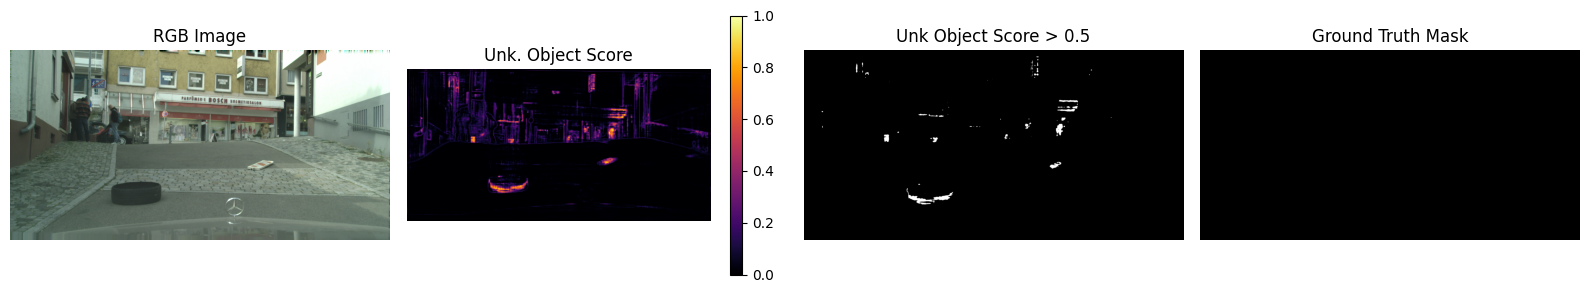

In [51]:
#@title Visualize result
df = dataset_test

import random
indices = random.randint(0,len(df))
image, mask = df[indices]
uoscore, unknown_score, objectness_score, pred_mask = model.unknown_obj_scores(image, uos_only=False)

# predicted_masks = val_sgmd >= lamhat
# Calculate empirical FNR
# print(f"The empirical FNR is: {false_negative_rate(predicted_masks, val_gt_masks)} and the threshold value is: {lamhat}")

print(f"The threshold value is: {0.5}")

visualize_unknown_detection(
    rgb_image=image,
    unk_obj_score=uoscore,
    gt_mask=mask.squeeze(0),
    threshold=0.5,
      )

In [52]:
#@title Problem setup
# n=len(dataset_calibration) # number of calibration points
n=100
alpha = 0.1 # 1-alpha is the desired false negative rate

def false_negative_rate(pred_masks, true_masks):
    return 1-((pred_masks * true_masks).sum(axis=1).sum(axis=1)/true_masks.sum(axis=1).sum(axis=1)).mean()

if alpha = 10%

“On average, across images in the test set, I want the proportion of ground-truth positive (obstacle) pixels that are missed (i.e., predicted as negative) to be no more than 10%.”

For a pixel that should be labeled "obstacle", there’s at most a 10% chance (on average) that the model will miss it.

In [53]:
def false_negative_rate_batched(predicted_scores, ground_truth_masks, threshold, batch_size=32):
    """
    Computes the average False Negative Rate (FNR) over a dataset in batches,
    skipping samples where the ground truth has no positives.

    Args:
        predicted_scores (np.ndarray): Array of shape [N, H, W] with per-pixel predicted scores.
        ground_truth_masks (np.ndarray): Binary array of shape [N, H, W] with ground truth labels.
        threshold (float): Threshold to convert predicted scores into binary masks.
        batch_size (int): Number of samples to process at once.

    Returns:
        float: Average false negative rate across valid samples.
    """
    num_samples = predicted_scores.shape[0]
    # print(f'num_samples: {num_samples}' )
    fnr_values = []

    for start_idx in range(0, num_samples, batch_size):
        end_idx = start_idx + batch_size

        # Binarize predictions using threshold
        binary_predictions = (predicted_scores[start_idx:end_idx] >= threshold).astype(np.float32)
        # print(f'binary_predictions.shape: {binary_predictions.shape}')

        # Get ground truth batch
        gt_batch = ground_truth_masks[start_idx:end_idx].astype(np.float32)
        # print(f'gt_batch.shape: {binary_predictions.shape}')

        # Compute per-sample counts
        true_positives = (binary_predictions * gt_batch).sum(axis=(1, 2))
        total_positives = gt_batch.sum(axis=(1, 2))
        # print(f'true_positives.shape: {true_positives.tolist().size}')
        # print(f'total_positives.shape: {total_positives.tolist().size}')


        for tp, total in zip(true_positives.tolist(), total_positives.tolist()):
            # print(f'true_positives: {tp}')
            # print(f'total: {total}')
            if total == 0:
                # print("⚠️ Warning: Skipping sample with no positives in ground truth.")
                continue  # Skip this sample
            recall = tp / total
            fnr = 1.0 - recall
            fnr_values.append(fnr)

        # Optional: free memory
        del binary_predictions, gt_batch, true_positives, total_positives

    if len(fnr_values) == 0:
        raise ValueError("All samples had empty ground truth masks. FNR cannot be computed.")
    # print(f'fnr_values: {fnr_values}')
    return np.mean(fnr_values)


In [54]:
# Split the unknown object scores into calibration and validation sets (save the shuffling)
# idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
# np.random.shuffle(idx)
# cal_sgmd, val_sgmd = sgmd[idx,:], sgmd[~idx,:]
# cal_gt_masks, val_gt_masks = gt_masks[idx], gt_masks[~idx]

In [55]:
def lamhat_threshold(lam):
    return false_negative_rate_batched(uos, gt_masks, lam, batch_size=16) - ((n+1)/n * alpha - 1/n)
    # return false_negative_rate(uos>=lam, gt_masks) - ((n+1)/n * alpha - 1/n)


In [56]:
# print("lam=0:", lamhat_threshold(0))
# print("lam=1:", lamhat_threshold(1))

In [57]:
from scipy.optimize import brentq

lamhat = brentq(lamhat_threshold, 0, 1)
print(f'Lambda found: {lamhat}')

Lambda found: 0.0008667948127862475


In [58]:
fnr = false_negative_rate_batched(uos, gt_masks, lamhat, batch_size=16)
print(f'False Negative Rate is {fnr} with a  threshold of {lamhat}, and the fnr limit set was {alpha}')

False Negative Rate is 0.09099435156850169 with a  threshold of 0.0008667948127862475, and the fnr limit set was 0.1


uoscore.shape, torch.Size([1024, 2048])
The threshold value is: 0.0008667948127862475


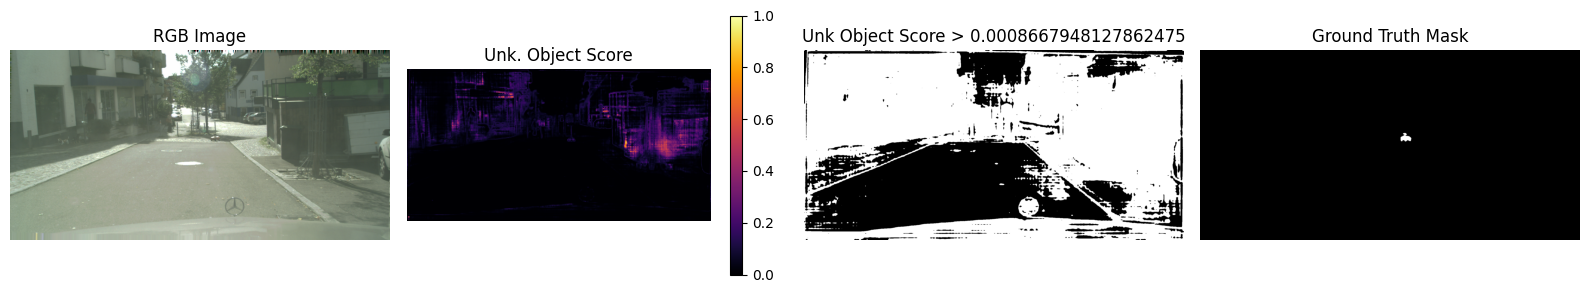

In [59]:
#@title Visualize result
df = dataset_test

import random
index = random.randint(0,(len(dataset_test)))
image, mask = df[index]
uoscore, unknown_score, objectness_score, pred_mask = model.unknown_obj_scores(image, uos_only=False)

# predicted_masks = val_sgmd >= lamhat
# Calculate empirical FNR
# print(f"The empirical FNR is: {false_negative_rate(predicted_masks, val_gt_masks)} and the threshold value is: {lamhat}")

print(f'uoscore.shape, {uoscore.shape}')
print(f"The threshold value is: {lamhat}")


visualize_unknown_detection(
    rgb_image=image,
    unk_obj_score=uoscore,
    gt_mask=mask.squeeze(0),
    threshold=lamhat,
      )

# UOS Evaluation using LostAndFound Test Set

In [60]:
#@title Subset for pre testing
# Define the size of the calibration set
pretest_size = 100

dataset_pretest = torch.utils.data.Subset(dataset_test, list(range(pretest_size)))
print(f"Pre test dataset size: {len(dataset_pretest)}")

dpt = dataset_pretest
all_gt_mask = []
all_unk_obj_score = []
for idx in tqdm(range(len(dataset_pretest))):
  image, mask = dc[idx]
  unknown_obj_score = model.unknown_obj_scores(image, uos_only=True)
  all_unk_obj_score.append(unknown_obj_score)
  all_gt_mask.append(mask)

gt_masks_tensor = torch.stack(all_gt_mask, dim=0)
unknown_obj_score_tensor = torch.stack(all_unk_obj_score, dim=0)
gt_masks_tensor = gt_masks_tensor.squeeze(1)
print(f'gt_mask_tensor shape: {gt_masks_tensor.shape}')
print(f'unknown_obj_score shape: {unknown_obj_score_tensor.shape}')


Pre test dataset size: 100


100%|██████████| 100/100 [00:24<00:00,  4.11it/s]

gt_mask_tensor shape: torch.Size([100, 1024, 2048])
unknown_obj_score shape: torch.Size([100, 1024, 2048])


In [61]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc = roc_auc_score(gt_masks_tensor.flatten().cpu(), unknown_obj_score_tensor.flatten().cpu())
aps = average_precision_score(gt_masks_tensor.flatten().cpu(), unknown_obj_score_tensor.flatten().cpu())

print(f'Area Under the ROC Curve: {roc}')
print(f'Average Precision:{aps} ')

Area Under the ROC Curve: 0.9458594013367154
Average Precision:0.038580205759348944 


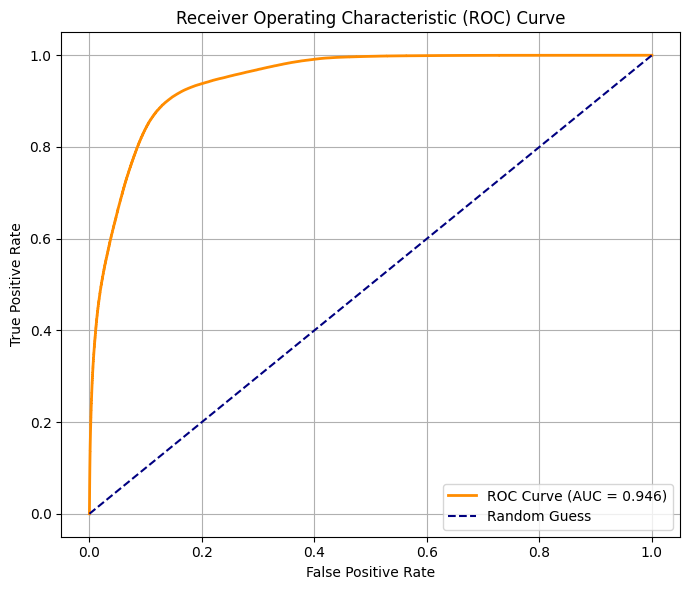

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score

# Dummy example data — in practice, replace with your model's output
# For demonstration, generate synthetic binary labels and prediction scores
np.random.seed(42)
y_true = gt_masks_tensor.cpu().numpy().flatten()
y_score = unknown_obj_score_tensor.cpu().numpy().flatten()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=1.5, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

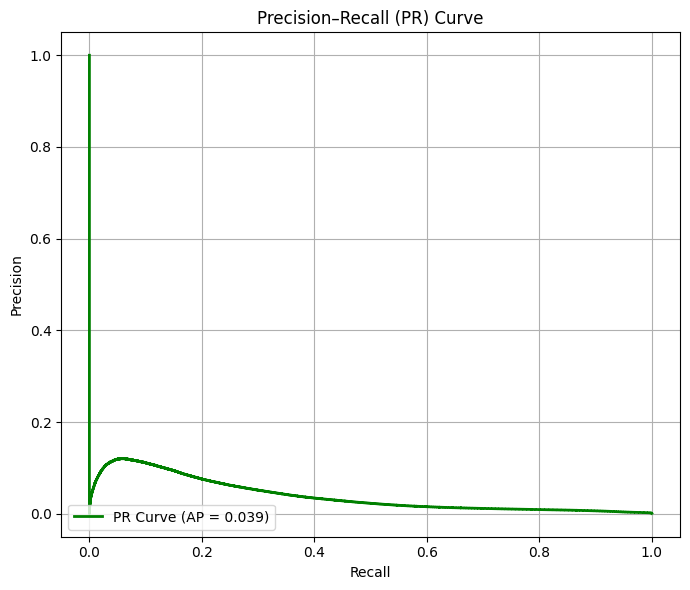

When the model identifies obstacle pixels, only about 3.86% predicted obstacle pixels are actually correct. In other words, 96.14% of the detections are false positives.


In [63]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall values
precision, recall, _ = precision_recall_curve(gt_masks_tensor.flatten().cpu(), unknown_obj_score_tensor.flatten().cpu())
ap = average_precision_score(gt_masks_tensor.flatten().cpu(), unknown_obj_score_tensor.flatten().cpu())

# Plot Precision-Recall curve
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f"PR Curve (AP = {ap:.3f})", color="green", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (PR) Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"When the model identifies obstacle pixels, only about {ap*100:.2f}% predicted obstacle pixels are actually correct. In other words, {100-ap*100:.2f}% of the detections are false positives.")

In [64]:
from sklearn.metrics import roc_curve

def fpr_at_95_tpr(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    # Find the first index where TPR >= 0.95
    idx = np.searchsorted(tpr, 0.95)
    return fpr[idx] if idx < len(fpr) else 1.0


y_true = gt_masks_tensor.flatten().cpu()
y_score = unknown_obj_score_tensor.flatten().cpu()
# Compute FPR at 95% TPR
fpr95 = fpr_at_95_tpr(y_true, y_score)
print(f'When the model successfully detects 95% of all obstacle pixels, it also predicts {fpr95*100:.2f}% of background pixels as false positives')

When the model successfully detects 95% of all obstacle pixels, it also predicts 23.52% of background pixels as false positives
